In [35]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as pltfont
from scipy import spatial
from scipy.cluster import hierarchy
from pyhpo import Ontology, HPOSet
from HPOFunctions import *
from clusteringFunctions import *
from sklearn.cluster import AgglomerativeClustering
_ = Ontology()

# -------------------------------------------------------------------

### **Import pre-processed and filtered DECIPHER dataset**
- Get propagated terms for each patient.
- Remove broad terms: 'All' and 'Phenotypic abnormality'

In [36]:
# Read DECIPHER output csv from DECIPHERDataHandling.ipynb 
decipherData = pd.read_csv('./DataHandlingOutput/decipherFiltered.csv')

# Find the number of patients
patientFreq = decipherData.shape[0]
print(f'Number of patients: {patientFreq}')

# Split the string HPO terms into a list
decipherData['HPOList'] = decipherData['propagatedTerms'].str.split('|')
decipherData = decipherData.reset_index()

# Remove broadest terms: 'All'
for i in range(0, len(decipherData)):
    if "All" in decipherData['HPOList'][i]:
        decipherData['HPOList'][i].remove("All")

# Remove broadest terms: 'Phenotypic abnormality'
for i in range(0, len(decipherData)):
    if "Phenotypic abnormality" in decipherData['HPOList'][i]:
        decipherData['HPOList'][i].remove("Phenotypic abnormality")

Number of patients: 462


### **Identify representative terms for each gene group**
- Group patients by gene and gather all HPO terms for each gene group
- Select 'representative' terms for each group by retaining terms present in 2 or 20% of patients (dependent on group size)
- Identify number of terms per group

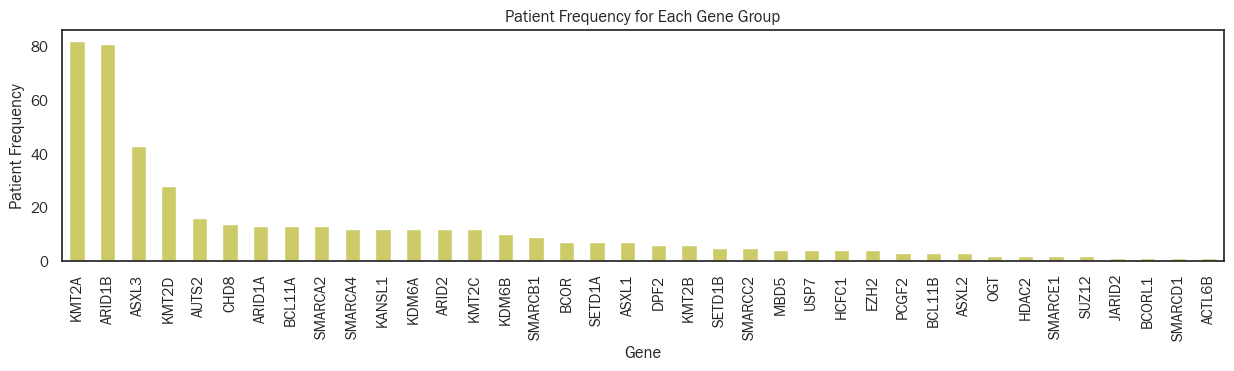

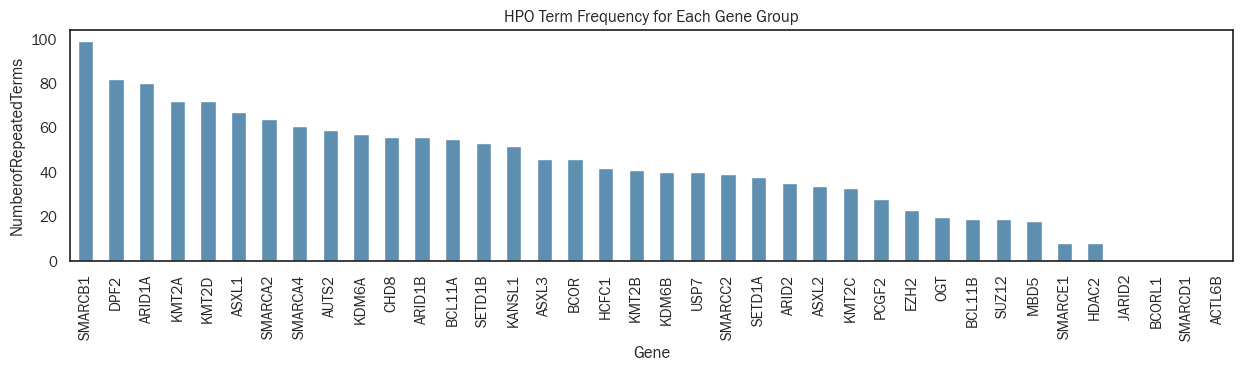

In [37]:
# Group by gene, aggregate all the hpo terms into a list with only unique HPO terms, and count how many have been grouped
decipherGrouped = decipherData.groupby('gene').agg({'HPOList': lambda x: list([item for sublist in x for item in sublist]), '# patient_id': lambda x: list(x)})
decipherGrouped['NumberofPatients'] = decipherGrouped['# patient_id'].apply(len)

# Get number of propagated terms per gene
decipherGrouped['NumberofTerms'] = decipherGrouped['HPOList'].apply(len)

# Create set (unique terms per gene)
decipherGrouped['HPOSet'] = decipherGrouped['HPOList'].apply(set)

# Get number of unique terms per gene
decipherGrouped['NumberofUniqueTerms'] = decipherGrouped['HPOSet'].apply(len)

# Identify terms present in more than one patient (repeated terms)
decipherGrouped['RepeatedTerms'] = ''
for i in range(0, len(decipherGrouped)): 
    if decipherGrouped['NumberofPatients'][i] > 5:
        decipherGrouped['RepeatedTerms'][i] = [x for x in decipherGrouped['HPOList'][i] if decipherGrouped['HPOList'][i].count(x) > 0.2*(decipherGrouped['NumberofPatients'][i])]
    else:
        decipherGrouped['RepeatedTerms'][i] = [x for x in decipherGrouped['HPOList'][i] if decipherGrouped['HPOList'][i].count(x) >= 2]

# Get number of unique repeated terms
decipherGrouped['RepeatedTerms'] = decipherGrouped['RepeatedTerms'].apply(set).apply(list)
decipherGrouped['NumberofRepeatedTerms'] = decipherGrouped['RepeatedTerms'].apply(len)

# Plot the number of patients in each group
plt.figure(figsize=(15, 3))
sns.set_theme(style= 'white', font_scale=1, font="Franklin Gothic Book", palette=['#cdcb68'])
decipherGrouped['NumberofPatients'].sort_values(ascending=False).plot(kind='bar')
plt.title('Patient Frequency for Each Gene Group')
plt.xlabel('Gene')
plt.ylabel('Patient Frequency')
plt.show()

# Plot number of repeated terms for each group
plt.figure(figsize=(15, 3))
sns.set_theme(style= 'white', font_scale=1, font="Franklin Gothic Book", palette=['#5f8fb0'])
decipherGrouped['NumberofRepeatedTerms'].sort_values(ascending=False).plot(kind='bar')
plt.title('HPO Term Frequency for Each Gene Group')
plt.xlabel('Gene')
plt.ylabel('NumberofRepeatedTerms')
plt.show()

### **Clean HPO term lists**
- Modify terms for each group: remove modifiers and obsolete terms
- Identify the median and IQR for term frequency across gene groups

In [38]:
# Convert the list of HPO terms into an instance of the HPOSet class
decipherGrouped['HPOSet'] = decipherGrouped['RepeatedTerms'].apply(HPOSet.from_queries).apply(HPOSet.remove_modifier).apply(HPOSet.replace_obsolete)
decipherGrouped['HPOSetChild'] = decipherGrouped['RepeatedTerms'].apply(HPOSet.from_queries).apply(HPOSet.remove_modifier).apply(HPOSet.replace_obsolete).apply(HPOSet.child_nodes)

# Get HPO list from set
decipherGrouped['HPOList'] = decipherGrouped['HPOSet'].apply(get_HPO_list)

# Get the median of the number of HPO terms.
medianTerms = decipherGrouped['HPOList'].apply(len).median()
q1 = decipherGrouped['HPOList'].apply(len).quantile(0.25)
q3 = decipherGrouped['HPOList'].apply(len).quantile(0.75) 
iqr = q3-q1
upperOutlier = q3 + 1.5 * iqr
print(f'Upper Outlier: {upperOutlier}')
print(f'Q1: {q1}')

# Select genes that have a greater number of HPO terms than the median.
groupsAboveMedian = decipherGrouped[decipherGrouped['HPOList'].apply(len) > upperOutlier]

Upper Outlier: 110.75
Q1: 20.75


### **Equalise terms**
- Approximately equalise the number of terms for each group, filtering up to the median
- NOTE: upper outlier is above the maximum value, so no gene lists were reduced here (ie code below for filtering using IC is redundant for this analysis)
- Remove groups with term frequency below the Q1 value

In [39]:
# Filter by retaining HPO terms with the highest IC (information content) up to the median number of HPO terms
groupsAboveMedian['filteredHPOList'] = groupsAboveMedian['HPOSet'].apply(filter_highest_ic_terms, max_number_of_terms=int(upperOutlier), list_or_object='list')
groupsAboveMedian['filteredHPOSet'] = groupsAboveMedian['filteredHPOList'].apply(HPOSet.from_queries)
merge = decipherGrouped.merge(groupsAboveMedian, how='left', left_index=True, right_index=True)
decipherGrouped['filteredHPOList'] = merge['filteredHPOList'].fillna(merge['HPOList_x'])
decipherGrouped['filteredHPOSet'] = merge['filteredHPOSet'].fillna(merge['HPOSet_x'])
decipherGrouped['filteredHPOListLength'] = decipherGrouped['filteredHPOList'].apply(len)

# Save csv of representative & all repeated terms & all child nodes of the repeated terms
decipherGrouped['repeatedHPOSet'] = decipherGrouped['RepeatedTerms'].apply(HPOSet.from_queries)
decipherGrouped['repeatedHPOSetChild'] = decipherGrouped['RepeatedTerms'].apply(HPOSet.from_queries).apply(HPOSet.child_nodes)
decipherGrouped['repeatedHPOSetChildLength'] = decipherGrouped['repeatedHPOSetChild'].apply(len)
decipherGrouped = decipherGrouped.reset_index()
decipherGrouped.to_csv('./ClusteringGeneGroupsOutput/decipherGrouped.csv')

# Filter out gene groups with too few terms 
decipherGrouped = decipherGrouped[decipherGrouped['filteredHPOListLength'] >= q1]

# -------------------------------------------------------------------

### **Identifying the semantic similarity between gene groups**
- Compute similarity between gene groups

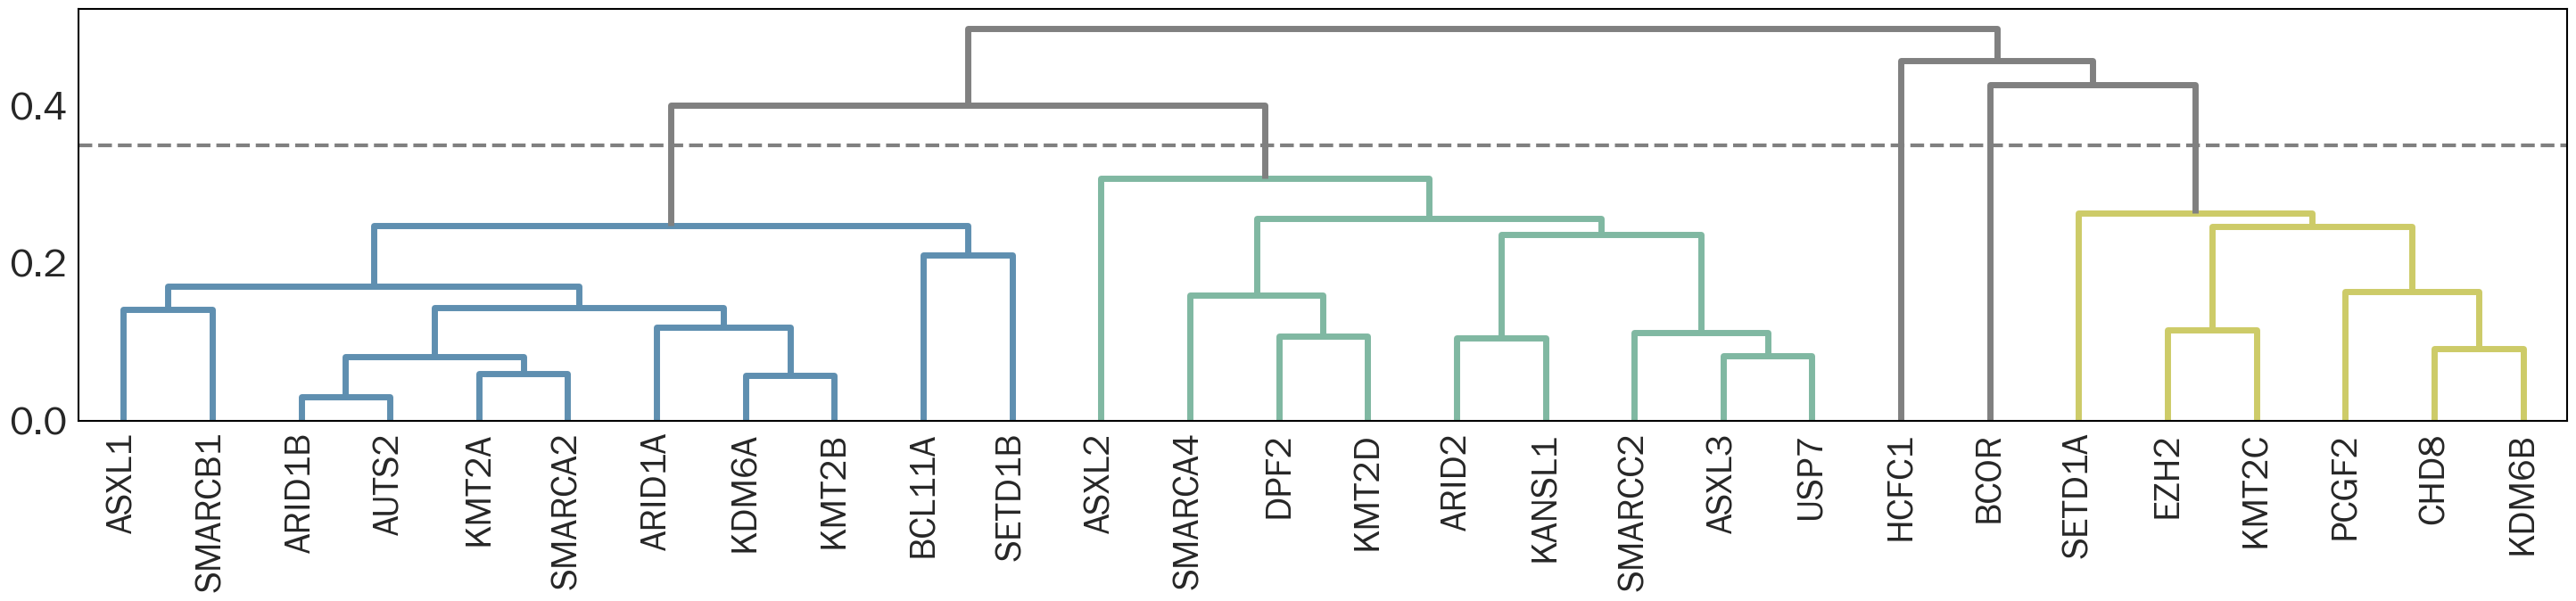

In [40]:
# Convert the pyhpo similarity function into a vectorized function
vsim = np.vectorize(HPOSet.similarity)

# Create two matrices that correspond with the pairs to compare in the next step
x, y = np.meshgrid(decipherGrouped['filteredHPOSet'], decipherGrouped['filteredHPOSet'])

# Semantic similarity is computed via the Graphic method, which checks for the sum of the IC of the common ancestors divided by the sum of the IC of the combined (union) parents of both terms (1 = identical terms) 
# The 'funSimAvg' method combines term-term similarity scores into set-set similarity scores
method, combine = 'graphic', 'funSimAvg'

# Run HPOSet.similarity on the whole of the two matrices
result = vsim(x, y, kind='omim', method=method, combine=combine)

# Set methods
affinity, linkageMethod = 'precomputed', 'complete'

# Convert result to pandas dataframe and add header and index
graphicHPOsim = pd.DataFrame(result, index=decipherGrouped.gene, columns=decipherGrouped.gene)

# Convert the similarity matrix to a distance matrix
graphicHPOdistance = (pd.DataFrame(np.max(result)-(np.array(result)), index=decipherGrouped.gene, columns=decipherGrouped.gene))

# Convert distance matrix to distance vector
distance1D = spatial.distance.squareform(np.max(result)-(np.array(result)), force='tovector', checks=False)

# Calculate hierarchical linkage from the distance vector
linkage = hierarchy.linkage(distance1D, method = linkageMethod)

# Plot dendrogram without heatmap
palette = ['#d10000', '#db5e00','#e4a52b','#e7d044','#cdcb68','#93b572','#80b8a2','#5f8fb0','#6e6e92','#804d7e','#bc5589','#db7979']
custom_params = {"axes.edgecolor": 'black', "axes.linewidth": 1.5}
plt.figure(figsize=(36,6))
sns.set_theme(style= 'whitegrid', font_scale=3, font="Franklin Gothic Book", rc=custom_params)
hierarchy.set_link_color_palette([palette[7], palette[6], palette[4]])
plt.rcParams['lines.linewidth'] = 5
hierarchy.dendrogram(linkage, labels=graphicHPOdistance.index, color_threshold=0.35, above_threshold_color='grey', leaf_font_size=30)
plt.axhline(y=0.35, c='grey', lw=3, linestyle='dashed')
plt.xticks(rotation=90)
plt.grid()
plt.savefig('./Figures/GeneGroupClusters.png', dpi=500, bbox_inches="tight")
plt.show()

### **Perform clustering**
- From the dendrogram it was decided that n=5 clusters was appropriate to try and identify specific phenotypic clusters

In [41]:
# Perform clustering
clustering = AgglomerativeClustering(n_clusters=5, affinity=affinity, linkage=linkageMethod).fit(graphicHPOdistance)

# Assign clusters to each patient
labels = clustering.labels_ + 1
decipherGrouped['cluster'] = labels

# Get filtered list length
decipherGrouped['filteredHPOListLength'] = decipherGrouped['filteredHPOList'].apply(len)

# Get counts for each cluster, and order by size
display(decipherGrouped.groupby(['cluster']).size().sort_values(ascending=False))

cluster
5    11
1     9
2     6
3     1
4     1
dtype: int64

### **Checking for bias arising from imbalanced patient term freqeuncies**
- Several graphs were made to check that clusters are not largely driven by HPO term frequency
- There does appear to be some bias arising from HPO term frequency

Text(0.5, 12.44444444444443, 'Cluster')

<Figure size 10000x300 with 0 Axes>

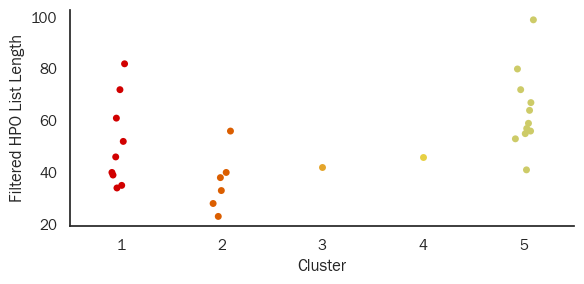

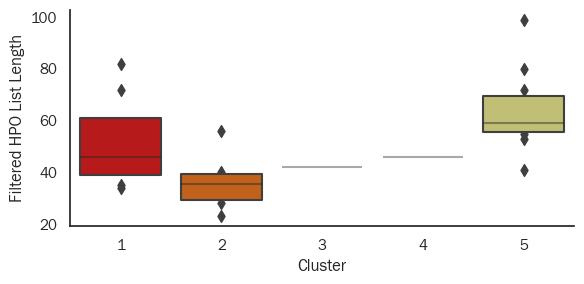

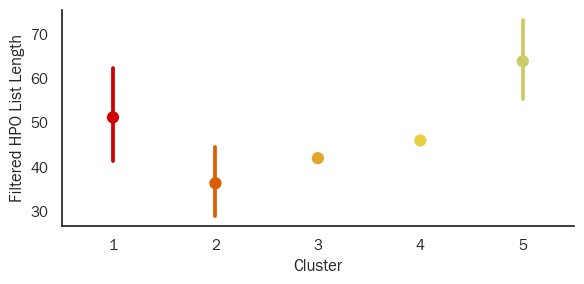

In [42]:
# Plot a categorical plots of filteredHPOListLength and the cluster number
plt.figure(figsize=(100, 3))
sns.set_theme(style='white', font="Franklin Gothic Book", font_scale=1)
sns.catplot(x='cluster', y='filteredHPOListLength', data=decipherGrouped, palette=palette, height=3, aspect=2)
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
sns.catplot(x='cluster', y='filteredHPOListLength', data=decipherGrouped, palette=palette, height=3, aspect=2, kind='boxen')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
plt.savefig('./Figures/GeneGroupClustersBox.png', dpi=500, bbox_inches="tight")
sns.catplot(x='cluster', y='filteredHPOListLength', data=decipherGrouped, palette=palette, height=3, aspect=2, kind='point')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')

# -------------------------------------------------------------------

### **Exploring the similarities & differences across gene groups**
- Get phenotypes that are uniquely associated with subclusters of gene groups 

In [43]:
decipherSubsetRepeated = decipherGrouped[["gene", "RepeatedTerms"]]
def find_unique_terms(gene_list):
    termsInGeneGroups = decipherSubsetRepeated[decipherSubsetRepeated['gene'].isin(gene_list)]
    termsInGeneGroups = (set.intersection(*map(set, termsInGeneGroups['RepeatedTerms'])))
    termsNotInAllGeneGroups = decipherSubsetRepeated[~decipherSubsetRepeated['gene'].isin(gene_list)]
    termsNotInAllGeneGroups = [item for sublist in termsNotInAllGeneGroups['RepeatedTerms'] for item in sublist]
    uniqueTermsInGeneGroups = termsInGeneGroups - set(termsNotInAllGeneGroups)
    print(uniqueTermsInGeneGroups)

find_unique_terms(list(decipherGrouped[decipherGrouped['cluster'] == 3]['gene']))

{'Sleep apnea', 'Respiratory tract infection', 'Recurrent respiratory infections', 'Abnormal pattern of respiration', 'Abnormal respiratory system physiology', 'Recurrent infections', 'Obstructive sleep apnea', 'Apnea', 'Abnormal lung morphology', 'Unusual infection'}


- Get phenotypes that overlap in subclusters of gene groups 

In [44]:
decipherSubsetRepeated = decipherGrouped[["gene", "RepeatedTerms"]]
def find_overlapping_terms(gene_list):
    termsInGeneGroups = decipherSubsetRepeated[decipherSubsetRepeated['gene'].isin(gene_list)]
    termsInGeneGroups = (set.intersection(*map(set, termsInGeneGroups['RepeatedTerms'])))
    return(termsInGeneGroups)

cluster1 = find_overlapping_terms(set(decipherGrouped[decipherGrouped['cluster'] == 1]['gene']))
cluster2 = find_overlapping_terms(set(decipherGrouped[decipherGrouped['cluster'] == 2]['gene']))
cluster5 = find_overlapping_terms(set(decipherGrouped[decipherGrouped['cluster'] == 5]['gene']))

print(cluster5 - cluster1 - cluster2)

{'Morphological central nervous system abnormality', 'Abnormal nervous system morphology', 'Abnormality of the eye', 'Abnormality of brain morphology', 'Neurodevelopmental delay', 'Abnormality of higher mental function', 'Abnormality of limbs'}


- Get all gene groups associated with a specific term

In [45]:
decipherGrouped = decipherGrouped.reset_index()
geneGroupsSpecificTerm = []
for i in range(0, len(decipherGrouped)):
    if 'Neurodevelopmental abnormality' in decipherGrouped['RepeatedTerms'][i]:
        geneGroupsSpecificTerm.append(decipherGrouped['gene'][i])
print(geneGroupsSpecificTerm)

['ARID1A', 'ARID1B', 'ARID2', 'ASXL1', 'ASXL2', 'ASXL3', 'AUTS2', 'BCL11A', 'BCOR', 'CHD8', 'DPF2', 'EZH2', 'HCFC1', 'KANSL1', 'KDM6A', 'KDM6B', 'KMT2A', 'KMT2B', 'KMT2C', 'KMT2D', 'PCGF2', 'SETD1A', 'SETD1B', 'SMARCA2', 'SMARCA4', 'SMARCB1', 'SMARCC2', 'USP7']


- Get all of the unique 'representative' terms for each group

In [46]:
# Get unique phenotypes for each group
for i in range(0, len(decipherGrouped)):
    outsideGeneGroupList = [item for sublist in [decipherGrouped[0:i]['RepeatedTerms'], decipherGrouped['RepeatedTerms'][i+1:len(decipherGrouped)]] for item in sublist]
    outsideGeneGroupList = [item for sublist in outsideGeneGroupList for item in sublist]
    geneGroupList = (decipherGrouped['RepeatedTerms'][i])
    geneGroupList = list(geneGroupList)
    geneGroupUnique = list((set(geneGroupList) - set(outsideGeneGroupList)))
    geneGroupUniqueHPOSet = HPOSet.from_queries(geneGroupUnique)
    geneGroupUniqueHPOSetChildren = HPOSet.child_nodes(geneGroupUniqueHPOSet)
    geneGroupListUniqueIDs = get_HPO_list(geneGroupUniqueHPOSetChildren)
    geneGroupListUniqueTerms = []
    for ID in geneGroupListUniqueIDs:
        term = get_HPO_term(ID)
        geneGroupListUniqueTerms.append(term)
    if len((set(geneGroupList) - set(outsideGeneGroupList))) > 0:
        print(f"{decipherGrouped['gene'][i]}: ", geneGroupListUniqueTerms)
    else:
        print(f"{decipherGrouped['gene'][i]}: ", 'No unique terms')

ARID1A:  ['Aplasia/Hypoplasia of toe', 'Abnormality of the periorbital region']
ARID1B:  No unique terms
ARID2:  No unique terms
ASXL1:  ['Proptosis', 'Abnormal renal morphology', 'Severe global developmental delay']
ASXL2:  ['Gastroesophageal reflux', 'Scoliosis']
ASXL3:  ['Feeding difficulties in infancy']
AUTS2:  No unique terms
BCL11A:  ['Recurrent hand flapping', 'Delayed gross motor development']
BCOR:  ['Abnormal external nose morphology', 'Atrial septal defect', 'Thyroglossal cyst', 'Microphthalmia', 'Developmental cataract']
CHD8:  ['Frontal bossing', 'Pes planus', 'Macrotia', 'Mild global developmental delay', 'Localized skin lesion', 'Proportionate tall stature', 'Overgrowth']
DPF2:  ['Downslanted palpebral fissures', 'Eczema', 'Broad thumb', 'Sagittal craniosynostosis']
EZH2:  ['Neoplasm by anatomical site', 'Large for gestational age']
HCFC1:  ['Obstructive sleep apnea', 'Recurrent respiratory infections']
KANSL1:  ['Hip dislocation', 'Abnormal breast morphology']
KDM6A:  

# -------------------------------------------------------------------

### **Prepare data for visualisation as a network**
- To visualise the complexities of this data better, prepare the data to visualise as a network
- To do this, the top two semantic similarity scores for each gene group were retained (this means each group may have more than 2 edges)

In [47]:
# Replace 1s with 0s (set similarity between the same groups to 0)
graphicHPOsim.replace(1, 0, inplace=True)

# Get top two similarity scores
graphicHPOsimTop2 = graphicHPOsim.mask(graphicHPOsim.rank(axis=0, method='min', ascending=False) > 2, 0)
graphicHPOsimTop2.to_csv('graphicHPOsimTop2.csv')

- Create binary matrices

In [48]:
# Create binary matrix for filtered HPO list
decipherSubset = decipherGrouped[["gene", "filteredHPOList"]]
decipherSubset["filteredHPOList"] = decipherSubset["filteredHPOList"].apply('|'.join)
decipherPhenotypes = decipherSubset['filteredHPOList'].str.get_dummies()
decipherBinaryMatrix = pd.concat([decipherSubset[['gene']], decipherPhenotypes], axis=1)
decipherBinaryMatrix.set_index('gene', inplace=True)

# Create binary matrix for all repeated terms 
decipherSubsetRepeated = decipherGrouped[["gene", "RepeatedTerms"]]
decipherSubsetRepeated["RepeatedTerms"] = decipherSubsetRepeated["RepeatedTerms"].apply('|'.join)
decipherPhenotypes = decipherSubsetRepeated['RepeatedTerms'].str.get_dummies()
decipherBinaryMatrixRepeated = pd.concat([decipherSubsetRepeated[['gene']], decipherPhenotypes], axis=1)
decipherBinaryMatrixRepeated.set_index('gene', inplace=True)
decipherBinaryMatrixRepeated.to_csv('./ClusteringGeneGroupsOutput/decipherBinaryMatrixRepeated.csv')

# Transpose binary matrix for all repeated terms
decipherBinaryMatrixRepeatedTranspose = decipherBinaryMatrixRepeated.transpose()
decipherBinaryMatrixRepeatedTranspose['sum']=decipherBinaryMatrixRepeatedTranspose.sum(axis=1)
decipherBinaryMatrixRepeatedTranspose = decipherBinaryMatrixRepeatedTranspose.sort_values(by='sum', ascending=False)
decipherBinaryMatrixRepeatedTranspose.to_csv('./ClusteringGeneGroupsOutput/decipherBinaryMatrixRepeatedTranspose.csv')

- Get key neurodevelopmental phenotypes, and a single parent term, to display using network

In [49]:
# Get all child terms of "Abnormality of the nervous system"
neurodevelopmentalIDs = []
neurodevelopmentalTerms = []
get_child_terms("Abnormality of the nervous system", neurodevelopmentalIDs, neurodevelopmentalTerms)

# Get terms present in at least 4 groups 
neurodevelopmental = decipherBinaryMatrixRepeatedTranspose[decipherBinaryMatrixRepeatedTranspose.index.isin(neurodevelopmentalTerms)]
neurodevelopmental = neurodevelopmental[neurodevelopmental['sum']>4]
neurodevelopmentalTermsFiltered = neurodevelopmental.index
neurodevelopmentalTermsFiltered = HPOSet.from_queries(neurodevelopmentalTermsFiltered)
neurodevelopmentalTermsFiltered = HPOSet.child_nodes(neurodevelopmentalTermsFiltered)
print(neurodevelopmentalTermsFiltered)

HPOSet: Autistic behavior, Seizure, Delayed speech and language development, Moderate global developmental delay, Intellectual disability, Microcephaly


- Get key dysmorphic phenotypes to display using network

In [50]:
# Get all child terms of "Head and neck abnormality" and "Abnormality of limbs" and "Abnormality of the integument" and "Growth abnormality"
dysmorphologyIDs = []
dysmorphologyTerms = []
get_child_terms("Head and neck abnormality", dysmorphologyIDs, dysmorphologyTerms)
get_child_terms("Abnormality of limbs", dysmorphologyIDs, dysmorphologyTerms)
get_child_terms("Abnormality of the integument", dysmorphologyIDs, dysmorphologyTerms)
get_child_terms("Growth abnormality", dysmorphologyIDs, dysmorphologyTerms)
get_child_terms("Abnormality of the skeletal system", dysmorphologyIDs, dysmorphologyTerms)

# Append parent terms
dysmorphologyTerms.append("Head and neck abnormality")
dysmorphologyTerms.append("Abnormality of limbs")
dysmorphologyTerms.append("Abnormality of the integument")
dysmorphologyTerms.append("Growth abnormality")

# Get terms present in at least 4 groups 
dysmorphology = decipherBinaryMatrixRepeatedTranspose[decipherBinaryMatrixRepeatedTranspose.index.isin(dysmorphologyTerms)]
dysmorphology = dysmorphology[dysmorphology['sum']>4]
dysmorphologyTermsFiltered = dysmorphology.index
dysmorphologyTermsFiltered = HPOSet.from_queries(dysmorphologyTermsFiltered)
dysmorphologyTermsFiltered = HPOSet.child_nodes(dysmorphologyTermsFiltered)
print(dysmorphologyTermsFiltered)

HPOSet: Abnormality of joint mobility, Growth delay, Abnormal oral cavity morphology, Abnormal nasal morphology, Abnormality of skin morphology, Abnormal ocular adnexa morphology, Abnormality of body height, Abnormal foot morphology, Abnormal hair quantity, Abnormality of finger, Microcephaly


- Combine specific phenotypes into broader groups to simplify visualisation

In [51]:
# Combine ID & GDD
decipherBinaryMatrixRepeated['Intellectual disability/GDD'] = decipherBinaryMatrixRepeated['Intellectual disability'] + decipherBinaryMatrixRepeated['Global developmental delay']
decipherBinaryMatrixRepeated['Intellectual disability/GDD'] = decipherBinaryMatrixRepeated['Intellectual disability/GDD'].replace(to_replace=2, value = 1)

# Combine facial dysmorphology phentypes
decipherBinaryMatrixRepeated['Facial dysmorphology'] = decipherBinaryMatrixRepeated['Abnormal oral morphology'] + decipherBinaryMatrixRepeated['Abnormal ocular adnexa morphology']+ decipherBinaryMatrixRepeated['Abnormal nasal morphology']
decipherBinaryMatrixRepeated['Facial dysmorphology'] = decipherBinaryMatrixRepeated['Facial dysmorphology'].replace(to_replace=3, value = 1)
decipherBinaryMatrixRepeated['Facial dysmorphology'] = decipherBinaryMatrixRepeated['Facial dysmorphology'].replace(to_replace=2, value = 1)

# Save as csv
decipherBinaryMatrixRepeated.to_csv('decipherBinaryMatrixRepeated.csv')

# -------------------------------------------------------------------